In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [36]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [ ]:
import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder

In [7]:
from networks import WMAutoencoder, WM_VAE

In [8]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [10]:
model = WM_VAE().cuda()
loss_func = autoencoder.vae_loss

In [11]:
# model = AdvancedAutoencoder(activation=nn.SiLU).cuda()
# loss_func = autoencoder.mse_loss

In [25]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
scheduler = ReduceLROnPlateau(optimizer, 'min', 0.9, 50, verbose=True)

In [14]:
from minerl.data import BufferedBatchIter

In [15]:
data = minerl.data.make(
    'MineRLObtainDiamond-v0', "data")
bbi = BufferedBatchIter(data, buffer_target_size=60000)


Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/marthinwurer/.pyenv/versions/3.9.6/lib/python3.9/multiprocessing/pro

In [16]:
def train_batch(inputs, model, optimizer, loss_func):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, latents = model(inputs)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = loss_func(inputs, outputs, latents)
    if isinstance(loss, tuple):
        loss[0].backward()
    else:
        loss.backward()
    
#     plot_grad_flow(model.named_parameters())

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss

In [17]:
bbi.avg_traj_size

0

In [18]:
bbi.traj_sizes

[]

In [19]:
losses = []
raw_losses = []
recons = []
kls = []

In [55]:
iterator = bbi.buffered_batch_iter(batch_size=BATCH_SIZE, num_epochs=1)

In [56]:
running_loss = 0
loss_steps = 50
epochs = 1

for epoch in range(epochs):
    with tqdm(enumerate(iterator, 0), unit="batch") as t:
        for i, data in t:
            # get the inputs
            current_state, action, reward, next_state, done = data
            image = torch.from_numpy(current_state['pov'].transpose(0, 3, 1, 2)).cuda() / 255

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func)
        
            # unpack loss
            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                raw_losses.append(loss)
                recons.append(full_loss[1].item())
                kls.append(full_loss[2].item())
            else:
                loss = full_loss.item()
                raw_losses.append(loss)


            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                losses.append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

65batch [00:05, 12.35batch/s, [1,    50] loss: 0.00229670]
100%|████████████████████████████████████████████████| 46648/46648 [00:03<00:00, 14252.74it/s]
247batch [00:29, 12.99batch/s, [1,   200] loss: 0.00185870]
100%|████████████████████████████████████████████████| 10716/10716 [00:00<00:00, 19169.06it/s]
289batch [00:34, 12.67batch/s, [1,   250] loss: 0.00189097]
100%|████████████████████████████████████████████████| 13009/13009 [00:01<00:00, 12164.76it/s]
339batch [00:40, 13.06batch/s, [1,   300] loss: 0.00224366]
100%|████████████████████████████████████████████████| 10890/10890 [00:00<00:00, 19335.98it/s]
381batch [00:46, 12.47batch/s, [1,   350] loss: 0.00202694]
100%|██████████████████████████████████████████████████| 8390/8390 [00:00<00:00, 19779.20it/s]
415batch [00:50, 12.03batch/s, [1,   400] loss: 0.00196734]
100%|████████████████████████████████████████████████| 10539/10539 [00:00<00:00, 11120.06it/s]
455batch [00:55, 12.13batch/s, [1,   450] loss: 0.00197366]
100%|██████

647batch [01:20, 11.93batch/s, [1,   600] loss: 0.00177638]
100%|████████████████████████████████████████████████| 13869/13869 [00:00<00:00, 18732.63it/s]
701batch [01:27, 12.67batch/s, [1,   700] loss: 0.00193163]
100%|███████████████████████████████████████████████████| 6532/6532 [00:00<00:00, 8261.99it/s]
727batch [01:31, 12.14batch/s, [1,   700] loss: 0.00193163]
100%|██████████████████████████████████████████████████| 8275/8275 [00:00<00:00, 18572.71it/s]
759batch [01:35, 11.76batch/s, [1,   750] loss: 0.00204842]
100%|████████████████████████████████████████████████| 29638/29638 [00:02<00:00, 14389.42it/s]
875batch [01:50, 12.62batch/s, [1,   850] loss: 0.00178073]
100%|████████████████████████████████████████████████| 18410/18410 [00:01<00:00, 12414.05it/s]
947batch [02:00, 12.48batch/s, [1,   900] loss: 0.00169953]
100%|████████████████████████████████████████████████| 18932/18932 [00:00<00:00, 19752.67it/s]
1021batch [02:09, 12.80batch/s, [1,  1000] loss: 0.00129581]
100%|████

100%|████████████████████████████████████████████████| 35479/35479 [00:02<00:00, 14426.70it/s]
1279batch [02:43, 12.35batch/s, [1,  1250] loss: 0.00157610]
100%|██████████████████████████████████████████████████| 5696/5696 [00:00<00:00, 19394.24it/s]
1301batch [02:45, 11.80batch/s, [1,  1300] loss: 0.00163866]
100%|██████████████████████████████████████████████████| 3611/3611 [00:00<00:00, 15749.79it/s]
1315batch [02:47, 10.58batch/s, [1,  1300] loss: 0.00163866]
100%|██████████████████████████████████████████████████| 8996/8996 [00:00<00:00, 20182.36it/s]
1351batch [02:52, 12.76batch/s, [1,  1350] loss: 0.00172714]
100%|████████████████████████████████████████████████| 12453/12453 [00:01<00:00, 11586.52it/s]
1399batch [02:59, 12.68batch/s, [1,  1400] loss: 0.00169228]
100%|████████████████████████████████████████████████| 11572/11572 [00:00<00:00, 16852.34it/s]
1445batch [03:05, 11.84batch/s, [1,  1400] loss: 0.00169228]
100%|██████████████████████████████████████████████████| 3342/33

100%|███████████████████████████████████████████████████| 6710/6710 [00:00<00:00, 8062.53it/s]
1769batch [03:48, 11.80batch/s, [1,  1750] loss: 0.00206891]
100%|██████████████████████████████████████████████████| 4135/4135 [00:00<00:00, 18283.01it/s]
1785batch [03:50, 11.17batch/s, [1,  1750] loss: 0.00206891]
100%|██████████████████████████████████████████████████| 8184/8184 [00:00<00:00, 19003.94it/s]
1817batch [03:54, 12.18batch/s, [1,  1800] loss: 0.00211131]
100%|██████████████████████████████████████████████████| 2906/2906 [00:00<00:00, 18339.33it/s]
1827batch [03:55, 10.11batch/s, [1,  1800] loss: 0.00211131]
100%|████████████████████████████████████████████████| 18627/18627 [00:01<00:00, 13164.71it/s]
1901batch [04:05, 12.51batch/s, [1,  1900] loss: 0.00234427]
100%|████████████████████████████████████████████████| 10133/10133 [00:00<00:00, 18457.73it/s]
1939batch [04:10, 12.61batch/s, [1,  1900] loss: 0.00234427]
100%|████████████████████████████████████████████████| 12141/121

100%|████████████████████████████████████████████████| 26336/26336 [00:01<00:00, 13727.45it/s]
2317batch [05:00, 12.36batch/s, [1,  2300] loss: 0.00221961]
100%|████████████████████████████████████████████████| 44175/44175 [00:03<00:00, 12823.89it/s]
2489batch [05:24, 12.11batch/s, [1,  2450] loss: 0.00183881]
100%|████████████████████████████████████████████████| 15781/15781 [00:00<00:00, 20633.66it/s]
2551batch [05:32, 12.62batch/s, [1,  2550] loss: 0.00156728]
100%|███████████████████████████████████████████████████| 9376/9376 [00:00<00:00, 9469.66it/s]
2588batch [05:37, 12.47batch/s, [1,  2550] loss: 0.00156728]
100%|████████████████████████████████████████████████| 12224/12224 [00:00<00:00, 20530.49it/s]
2636batch [05:43, 12.02batch/s, [1,  2600] loss: 0.00158821]
100%|███████████████████████████████████████████████████| 6546/6546 [00:00<00:00, 7970.66it/s]
2660batch [05:46, 11.51batch/s, [1,  2650] loss: 0.00150664]
100%|████████████████████████████████████████████████| 10467/104

100%|███████████████████████████████████████████████████| 4402/4402 [00:00<00:00, 6229.46it/s]
2866batch [06:14, 11.01batch/s, [1,  2850] loss: 0.00289385]
100%|████████████████████████████████████████████████| 10129/10129 [00:00<00:00, 20139.73it/s]
2904batch [06:19, 12.42batch/s, [1,  2900] loss: 0.00285374]
100%|████████████████████████████████████████████████| 16430/16430 [00:01<00:00, 12154.73it/s]
2968batch [06:28, 12.63batch/s, [1,  2950] loss: 0.00273249]
100%|████████████████████████████████████████████████| 69526/69526 [00:04<00:00, 14907.24it/s]
3240batch [07:07, 12.30batch/s, [1,  3200] loss: 0.00271333]
100%|██████████████████████████████████████████████████| 6112/6112 [00:00<00:00, 19627.91it/s]
3264batch [07:10, 11.87batch/s, [1,  3250] loss: 0.00265031]
100%|██████████████████████████████████████████████████| 7363/7363 [00:00<00:00, 20107.46it/s]
3294batch [07:14, 11.96batch/s, [1,  3250] loss: 0.00265031]
100%|██████████████████████████████████████████████████| 1894/18

100%|████████████████████████████████████████████████| 27235/27235 [00:02<00:00, 10920.64it/s]
3492batch [07:40, 12.08batch/s, [1,  3450] loss: 0.00281159]
100%|████████████████████████████████████████████████| 14891/14891 [00:00<00:00, 18808.36it/s]
3550batch [07:47, 12.64batch/s, [1,  3550] loss: 0.00241433]
100%|██████████████████████████████████████████████████| 1849/1849 [00:00<00:00, 20024.24it/s]
3558batch [07:48,  9.91batch/s, [1,  3550] loss: 0.00241433]
100%|██████████████████████████████████████████████████| 6581/6581 [00:00<00:00, 19405.31it/s]
3582batch [07:51, 11.48batch/s, [1,  3550] loss: 0.00241433]
100%|██████████████████████████████████████████████████| 5457/5457 [00:00<00:00, 19380.85it/s]
3604batch [07:54, 11.79batch/s, [1,  3600] loss: 0.00255857]
100%|████████████████████████████████████████████████| 26128/26128 [00:02<00:00, 10974.64it/s]
3706batch [08:08, 12.31batch/s, [1,  3700] loss: 0.00217268]
100%|████████████████████████████████████████████████| 16191/161

100%|████████████████████████████████████████████████| 16614/16614 [00:01<00:00, 11732.83it/s]
4014batch [08:49, 12.30batch/s, [1,  4000] loss: 0.00182303]
100%|████████████████████████████████████████████████| 13702/13702 [00:00<00:00, 19032.69it/s]
4068batch [08:56, 12.60batch/s, [1,  4050] loss: 0.00186106]
100%|████████████████████████████████████████████████| 13889/13889 [00:01<00:00, 11050.67it/s]
4122batch [09:03, 12.50batch/s, [1,  4100] loss: 0.00191487]
100%|██████████████████████████████████████████████████| 8580/8580 [00:00<00:00, 18724.86it/s]
4156batch [09:08, 12.14batch/s, [1,  4150] loss: 0.00196063]
100%|████████████████████████████████████████████████| 30998/30998 [00:02<00:00, 14766.55it/s]
4276batch [09:23, 12.35batch/s, [1,  4250] loss: 0.00181512]
100%|██████████████████████████████████████████████████| 5458/5458 [00:00<00:00, 19454.03it/s]
4298batch [09:25, 11.84batch/s, [1,  4250] loss: 0.00181512]
100%|██████████████████████████████████████████████████| 8867/88

100%|██████████████████████████████████████████████████| 7763/7763 [00:00<00:00, 19410.34it/s]
4576batch [10:03, 12.28batch/s, [1,  4550] loss: 0.00196862]
100%|██████████████████████████████████████████████████| 9620/9620 [00:00<00:00, 19095.24it/s]
4614batch [10:07, 12.72batch/s, [1,  4600] loss: 0.00186573]
100%|██████████████████████████████████████████████████| 2196/2196 [00:00<00:00, 17683.86it/s]
4622batch [10:09,  9.86batch/s, [1,  4600] loss: 0.00186573]
100%|████████████████████████████████████████████████| 24698/24698 [00:01<00:00, 13537.76it/s]
4720batch [10:21, 12.64batch/s, [1,  4700] loss: 0.00180841]
100%|████████████████████████████████████████████████| 41681/41681 [00:02<00:00, 15006.12it/s]
4882batch [10:43, 12.83batch/s, [1,  4850] loss: 0.00159049]
100%|███████████████████████████████████████████████████| 8968/8968 [00:00<00:00, 9668.45it/s]
4918batch [10:47, 11.99batch/s, [1,  4900] loss: 0.00161286]
100%|████████████████████████████████████████████████| 10453/104

100%|████████████████████████████████████████████████| 13314/13314 [00:00<00:00, 18256.31it/s]
5182batch [11:23, 12.80batch/s, [1,  5150] loss: 0.00174606]
100%|████████████████████████████████████████████████| 23958/23958 [00:01<00:00, 14541.39it/s]
5274batch [11:35, 12.49batch/s, [1,  5250] loss: 0.00171346]
100%|██████████████████████████████████████████████████| 1995/1995 [00:00<00:00, 18969.16it/s]
5282batch [11:36,  9.85batch/s, [1,  5250] loss: 0.00171346]
100%|████████████████████████████████████████████████| 26778/26778 [00:02<00:00, 11299.87it/s]
5388batch [11:50, 12.62batch/s, [1,  5350] loss: 0.00147596]
100%|████████████████████████████████████████████████| 34292/34292 [00:02<00:00, 14789.17it/s]
5521batch [12:09, 12.71batch/s, [1,  5500] loss: 0.00216531]
100%|████████████████████████████████████████████████| 27347/27347 [00:01<00:00, 13971.03it/s]
5627batch [12:22, 12.61batch/s, [1,  5600] loss: 0.00183964]
100%|██████████████████████████████████████████████████| 3450/34

100%|████████████████████████████████████████████████| 10656/10656 [00:00<00:00, 19300.07it/s]
5723batch [12:34, 12.79batch/s, [1,  5700] loss: 0.00209598]
100%|███████████████████████████████████████████████████| 9038/9038 [00:00<00:00, 9186.30it/s]
5759batch [12:40, 11.94batch/s, [1,  5750] loss: 0.00222229]
100%|████████████████████████████████████████████████| 19218/19218 [00:00<00:00, 20436.37it/s]
5833batch [12:49, 11.94batch/s, [1,  5800] loss: 0.00214140]
100%|████████████████████████████████████████████████| 65988/65988 [00:04<00:00, 13507.26it/s]
6091batch [13:24, 12.68batch/s, [1,  6050] loss: 0.00265971]
100%|████████████████████████████████████████████████| 12602/12602 [00:00<00:00, 19159.93it/s]
6141batch [13:30, 12.38batch/s, [1,  6100] loss: 0.00260092]
100%|██████████████████████████████████████████████████| 4514/4514 [00:00<00:00, 19082.74it/s]
6159batch [13:32, 11.02batch/s, [1,  6150] loss: 0.00254022]
100%|██████████████████████████████████████████████████| 5150/51

6311batch [13:53, 12.51batch/s, [1,  6300] loss: 0.00219485]
100%|████████████████████████████████████████████████| 13199/13199 [00:00<00:00, 19374.80it/s]
6363batch [13:59, 12.57batch/s, [1,  6350] loss: 0.00202329]
100%|████████████████████████████████████████████████| 26459/26459 [00:01<00:00, 14258.54it/s]
6465batch [14:12, 12.68batch/s, [1,  6450] loss: 0.00172196]
100%|████████████████████████████████████████████████| 27890/27890 [00:01<00:00, 14523.45it/s]
6575batch [14:27, 12.47batch/s, [1,  6550] loss: 0.00154684]
100%|██████████████████████████████████████████████████| 7575/7575 [00:00<00:00, 19487.37it/s]
6605batch [14:30, 12.45batch/s, [1,  6600] loss: 0.00150061]
100%|██████████████████████████████████████████████████| 2018/2018 [00:00<00:00, 18871.10it/s]
6613batch [14:31, 10.19batch/s, [1,  6600] loss: 0.00150061]
100%|████████████████████████████████████████████████| 17872/17872 [00:01<00:00, 13169.18it/s]
6681batch [14:40, 11.90batch/s, [1,  6650] loss: 0.00152385]
100

100%|████████████████████████████████████████████████| 15310/15310 [00:01<00:00, 11738.92it/s]
6919batch [15:12, 11.96batch/s, [1,  6900] loss: 0.00188592]
100%|██████████████████████████████████████████████████| 6761/6761 [00:00<00:00, 19940.56it/s]
6945batch [15:15, 12.48batch/s, [1,  6900] loss: 0.00188592]
100%|████████████████████████████████████████████████| 14370/14370 [00:00<00:00, 18134.24it/s]
7001batch [15:22, 12.59batch/s, [1,  7000] loss: 0.00151528]
100%|████████████████████████████████████████████████| 28815/28815 [00:01<00:00, 14842.35it/s]
7286batch [15:50,  7.67batch/s, [1,  7250] loss: 0.00122271]


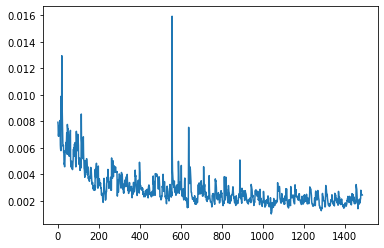

In [27]:
plt.plot(losses[10:])

In [19]:
59893*32

1916576

In [36]:
iterator2 = bbi.buffered_batch_iter(batch_size=1, num_epochs=1)

In [37]:
current_state, action, reward, next_state, done = next(iterator2)
image = torch.from_numpy(current_state['pov'].transpose(0, 3, 1, 2)).cuda() / 255

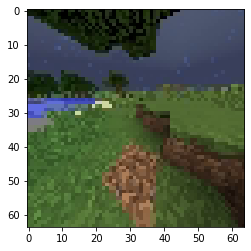

In [28]:
plt.imshow(current_state['pov'][0])

In [57]:
outputs, latents = model(image)

In [58]:
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

In [59]:
op.shape

(256, 64, 64, 3)

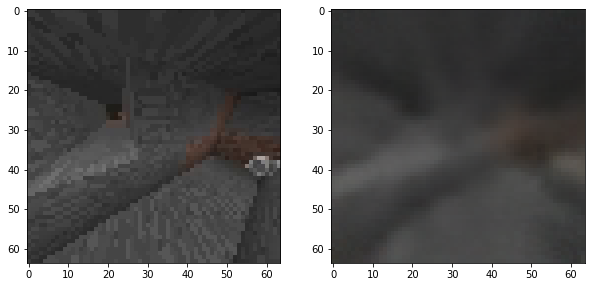

In [80]:
idx = 23
plt.subplot(1, 2, 1)
plt.imshow(current_state['pov'][idx])
plt.subplot(1, 2, 2)

plt.imshow(op[idx])

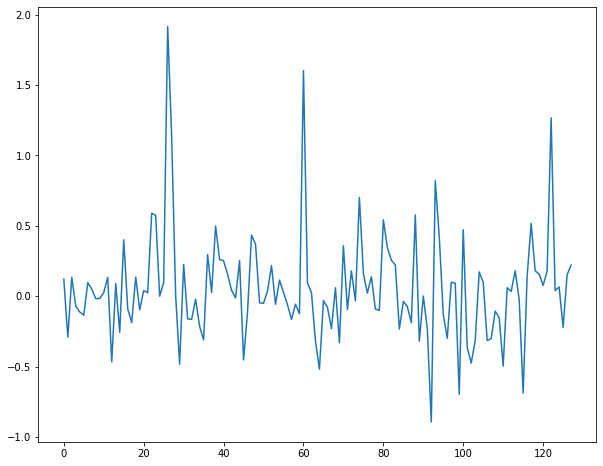

In [50]:
plt.plot(latents[0][0].detach().cpu().numpy())

In [28]:
mse = (np.square((current_state['pov'][0]/255.0 - op[0]))).mean()
mse

0.002087606703423508

In [107]:
from spectralpool import *
import utilities

In [108]:
dht = DiscreteHartleyTransform(image)

In [109]:
torch.view_as_real(torch.fft.fft2(image)).shape

torch.Size([1, 3, 64, 64, 2])

In [110]:
dht.shape

torch.Size([1, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Image data of dtype object cannot be converted to float

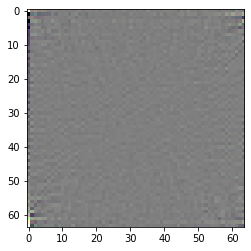

In [111]:
plt.imshow(utilities.view(dht[0]))

In [112]:
dht2 = DiscreteHartleyTransform(dht)

TypeError: Image data of dtype object cannot be converted to float

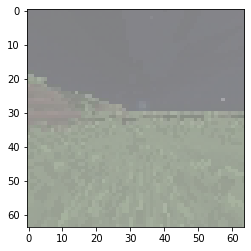

In [113]:
plt.imshow(utilities.view(dht2[0]))

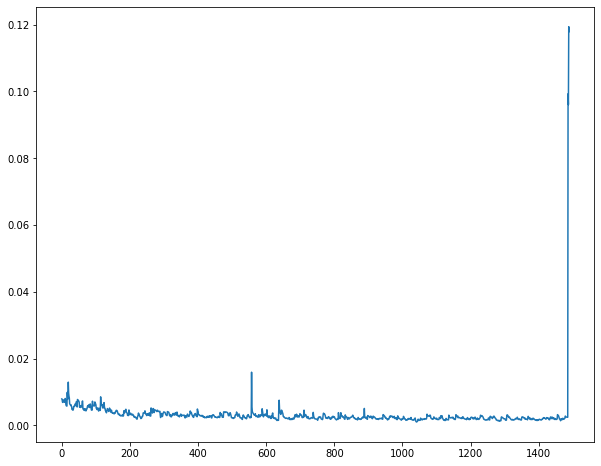

In [48]:
plt.plot(losses[10:])

In [36]:
58587//50

1171

In [39]:
losses = losses[-1170:]

In [59]:
from spectralpool import _spectral_crop, _spectral_pad

In [63]:
scale = 4.

In [64]:
H, W = image.size(-2), image.size(-1)
oheight, owidth = math.ceil(H * scale), math.ceil(W * scale)

# frequency cropping
if scale <= 1:
    all_together = _spectral_crop(dht, oheight, owidth)
else:
    all_together = _spectral_pad(input, dht, oheight, owidth)

# inverse Hartley transform
dht2 = DiscreteHartleyTransform(all_together)

TypeError: Image data of dtype object cannot be converted to float

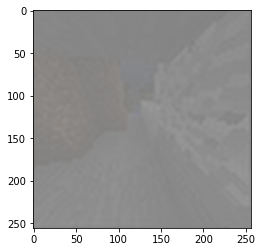

In [65]:
plt.imshow(utilities.view(dht2[0]))

In [39]:
from delve import CheckLayerSat

In [40]:
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=image.device)

added layer encoder-0
Skipping encoder-1
added layer encoder-2
Skipping encoder-3
added layer encoder-4
Skipping encoder-5
added layer encoder-6
Skipping encoder-7
added layer latent-mu
added layer latent-logvar
added layer unlatent
Skipping decoder-0
Skipping decoder-1
Skipping decoder-2
Skipping decoder-3
Skipping decoder-4
Skipping decoder-5
Skipping decoder-6
Skipping decoder-7


In [41]:
iterator = bbi.buffered_batch_iter(batch_size=BATCH_SIZE, num_epochs=1)

0batch [00:00, ?batch/s]
100%|████████████████████████████████████████████████| 24546/24546 [00:01<00:00, 20124.82it/s]

100%|████████████████████████████████████████████████| 11546/11546 [00:00<00:00, 22806.29it/s]

100%|████████████████████████████████████████████████| 25081/25081 [00:01<00:00, 16070.59it/s]
67batch [00:30, 13.38batch/s, [1,    50] loss: 0.00198565]
100%|████████████████████████████████████████████████| 10984/10984 [00:00<00:00, 20371.44it/s]
109batch [00:35, 13.23batch/s, [1,   100] loss: 0.00192131]
100%|████████████████████████████████████████████████| 18499/18499 [00:01<00:00, 14960.33it/s]
181batch [00:45, 13.17batch/s, [1,   150] loss: 0.00238779]
100%|████████████████████████████████████████████████| 21259/21259 [00:01<00:00, 14705.65it/s]
199batch [00:50,  3.92batch/s, [1,   200] loss: 0.00235844]

my_experiment_lsat_train_epoch_0.png


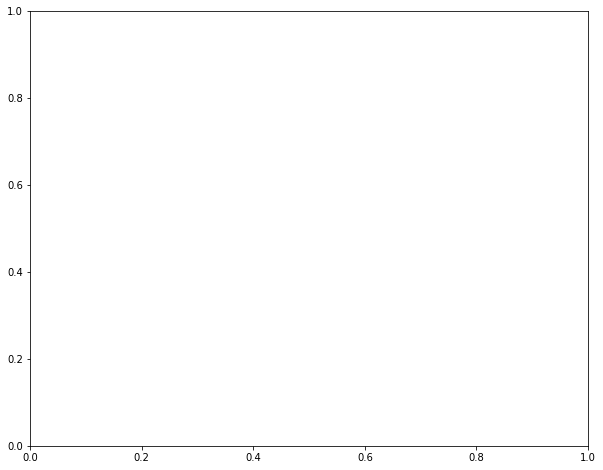

In [42]:
running_loss = 0
loss_steps = 50
epoch = 0
track_steps = 200

with tqdm(enumerate(iterator, 0), unit="batch") as t:
    for i, data in t:
        # get the inputs
        current_state, action, reward, next_state, done = data
        image = torch.from_numpy(current_state['pov'].transpose(0, 3, 1, 2)).cuda() / 255
        
#         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
        loss = train_batch(image, model, optimizer, loss_func)
        

        if loss is None or torch.isnan(loss).any():
            print("There's a NaN loss!")
            from IPython.core.debugger import Pdb; Pdb().set_trace()
            break

        # print statistics
        running_loss += loss.item()
        if i % loss_steps == loss_steps - 1:  # print every N mini-batches
            string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
            t.set_postfix_str(string)
            losses.append(running_loss)
            scheduler.step(running_loss)
            running_loss = 0.0
        if i % track_steps == track_steps - 1:  # print every N mini-batches
            tracker.add_saturations()
            break

In [46]:
class simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.deconv1 = nn.ConvTranspose2d(32, 3, 3)


In [48]:
simple_model = simple()
tracker2 = CheckLayerSat("my_experiment", save_to="plotcsv", modules=simple_model, device=image.device)

added layer conv1
Skipping deconv1


In [31]:
len(losses)//10

150

In [28]:
epoch_loss = []
chunk_size = len(losses)//10
for i in range(10):
    total = 0
    for j in range(chunk_size):
        total += losses[i * chunk_size + j]
    epoch_loss.append(total/chunk_size)

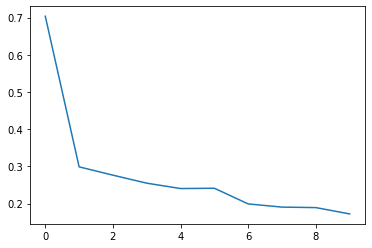

In [29]:
plt.plot(epoch_loss)